In [1]:
import pandas as pd

import os

import numpy as np


import matplotlib.pyplot as plt
import seaborn as sns

import anndata as ad
import glob
from sklearn.metrics import adjusted_rand_score

import warnings
warnings.filterwarnings("ignore")

import matplotlib
matplotlib.rcParams["pdf.fonttype"] = 42
matplotlib.rcParams["ps.fonttype"] = 42


In [2]:
import json

# Load configuration
with open("../config/config_notebooks.json", "r") as config_file:
    config = json.load(config_file)


In [3]:
## Try to plot the bootstrapped ARI patient values
df_boot = pd.DataFrame()
for model_type, names, benchmark_path in zip([config['retrained_model_list1_type'],
                                              config['retrained_model_list2_type']],
                                             [config['retrained_model_list1'],
                                              config['retrained_model_list2']],
                                             [config['retrained_benchmark_folder1'],
                                              config['retrained_benchmark_folder2']]):
    path_to_unsupervised_clustering = os.path.join(benchmark_path, "unsupervised_clustering_ARI", "kmeans")
    
    for name in names:
        print(f"Processing {name}...")
        bootstrapped_files = glob.glob(os.path.join(path_to_unsupervised_clustering, f"boostraped_ARI_patient_{name}_10*.json"))
        print(f"Found bootstrapped files: {bootstrapped_files}")
        if len(bootstrapped_files) > 0:
            with open(bootstrapped_files[0], "r") as f:
                ari_patient = json.load(f)
                
                df_boot[name] = ari_patient[name]


Processing uni...
Found bootstrapped files: ['../results/benchmark/TNBC/uni_explora_models/unsupervised_clustering_ARI/kmeans/boostraped_ARI_patient_uni_10_patients_old.json']
Processing uni_explora_kde_4096_prototypes...
Found bootstrapped files: ['../results/benchmark/TNBC/uni_explora_models/unsupervised_clustering_ARI/kmeans/boostraped_ARI_patient_uni_explora_kde_4096_prototypes_10_patients_old.json', '../results/benchmark/TNBC/uni_explora_models/unsupervised_clustering_ARI/kmeans/boostraped_ARI_patient_uni_explora_kde_4096_prototypes_10_19_patients.json']
Processing uni_explora_kde_16384_prototypes...
Found bootstrapped files: ['../results/benchmark/TNBC/uni_explora_models/unsupervised_clustering_ARI/kmeans/boostraped_ARI_patient_uni_explora_kde_16384_prototypes_10_patients_old.json', '../results/benchmark/TNBC/uni_explora_models/unsupervised_clustering_ARI/kmeans/boostraped_ARI_patient_uni_explora_kde_16384_prototypes_10_19_patients.json']
Processing uni_explora_kde_65536_prototyp

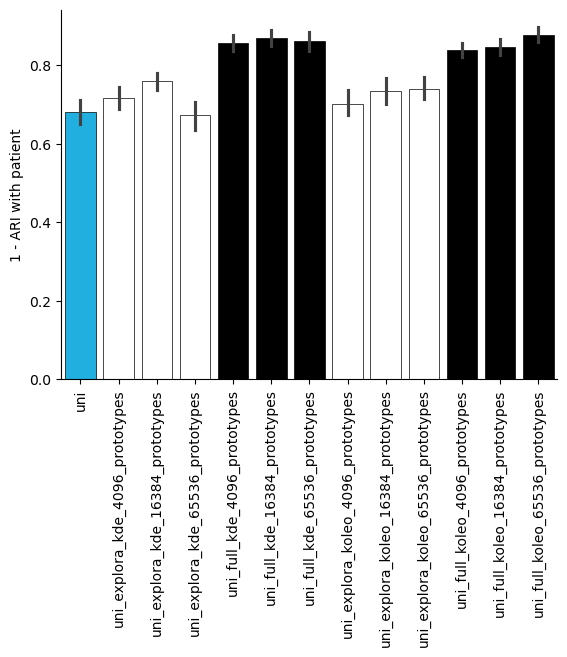

In [5]:
if len(df_boot) > 0:
  df_boot = df_boot.T.loc[["uni",
                "uni_explora_kde_4096_prototypes",
                "uni_explora_kde_16384_prototypes",
                  "uni_explora_kde_65536_prototypes",
                  "uni_full_kde_4096_prototypes",
                  "uni_full_kde_16384_prototypes",
                  "uni_full_kde_65536_prototypes",
                  "uni_explora_koleo_4096_prototypes",
                  "uni_explora_koleo_16384_prototypes",
                  "uni_explora_koleo_65536_prototypes",
                  "uni_full_koleo_4096_prototypes",
                  "uni_full_koleo_16384_prototypes",
                  "uni_full_koleo_65536_prototypes"]].T
  
  df_boot = 1 - df_boot
  
  sns.barplot(data=df_boot, 
            palette=["deepskyblue", 
                     "white", "white", "white", 
                     "black","black", "black", 
                     "white", "white", "white", 
                     "black", "black","black"], 
            linewidth=0.5,
            edgecolor="black",
            )
  plt.ylabel("1 - ARI with patient")
  plt.xticks(rotation=90)
  sns.despine()

In [3]:

ARI_batch = {}



for model_type, names, benchmark_path in zip([config['retrained_model_list1_type'],
                              config['retrained_model_list2_type']],
                              [config['retrained_model_list1'],
                                config['retrained_model_list2']],
                                [config['retrained_benchmark_folder1'],
                                config['retrained_benchmark_folder2']]):

        
        
    path_to_invasive_cancer_clustering_results = os.path.join(benchmark_path, "invasive_cancer_clustering")
    ARI_batch[model_type] = {}
    
    
    opti_clusters = pd.read_csv(os.path.join(path_to_invasive_cancer_clustering_results, config['invasive_cancer_clustering_algo'], "optimal_clusters.csv"), index_col=0)
    dfs = []


    for name in names:
        
        label_file = glob.glob(os.path.join(path_to_invasive_cancer_clustering_results, config['invasive_cancer_clustering_algo'], name, f"invasive_labels_{opti_clusters.loc[name, 'n_clusters']}_clusters_umap_min_dist_*_n_neighbors_*.csv"))[0]
        print(label_file)
        
        labels = pd.read_csv(label_file, index_col=0)
        labels['tumor'] = [idx.split("_")[0] for idx in labels.index]
        
        ARI_batch[model_type][name] = adjusted_rand_score(labels['tumor'], labels['predicted_label'])
            
           

FileNotFoundError: [Errno 2] No such file or directory: '../results/benchmark/TNBC/uni_explora_models/invasive_cancer_clustering/kmeans/optimal_clusters.csv'

In [ ]:
df_explora = pd.DataFrame(ARI_batch[config['retrained_model_list1_type']], index=["ARI"]).T
df_explora['batch effect'] = 1 - df_explora['ARI']
df_explora['model'] = config['retrained_model_list1_type']

df_full = pd.DataFrame(ARI_batch[config['retrained_model_list2_type']], index=["ARI"]).T
df_full['batch effect'] = 1 - df_full['ARI']
df_full['model'] = config['retrained_model_list2_type']

df_batch = pd.concat([df_explora, df_full])
df_batch


,ARI,batch effect,model
uni,0.070604,0.929396,explora
uni_explora_kde_4096_prototypes,0.040333,0.959667,explora
uni_explora_kde_16384_prototypes,0.065577,0.934423,explora
uni_explora_kde_65536_prototypes,0.083526,0.916474,explora
uni_explora_koleo_4096_prototypes,0.076173,0.923827,explora
uni_explora_koleo_16384_prototypes,0.042672,0.957328,explora
uni_explora_koleo_65536_prototypes,0.107834,0.892166,explora
uni,0.070604,0.929396,full
uni_full_kde_4096_prototypes,0.082477,0.917523,full
uni_full_kde_16384_prototypes,0.046448,0.953552,full


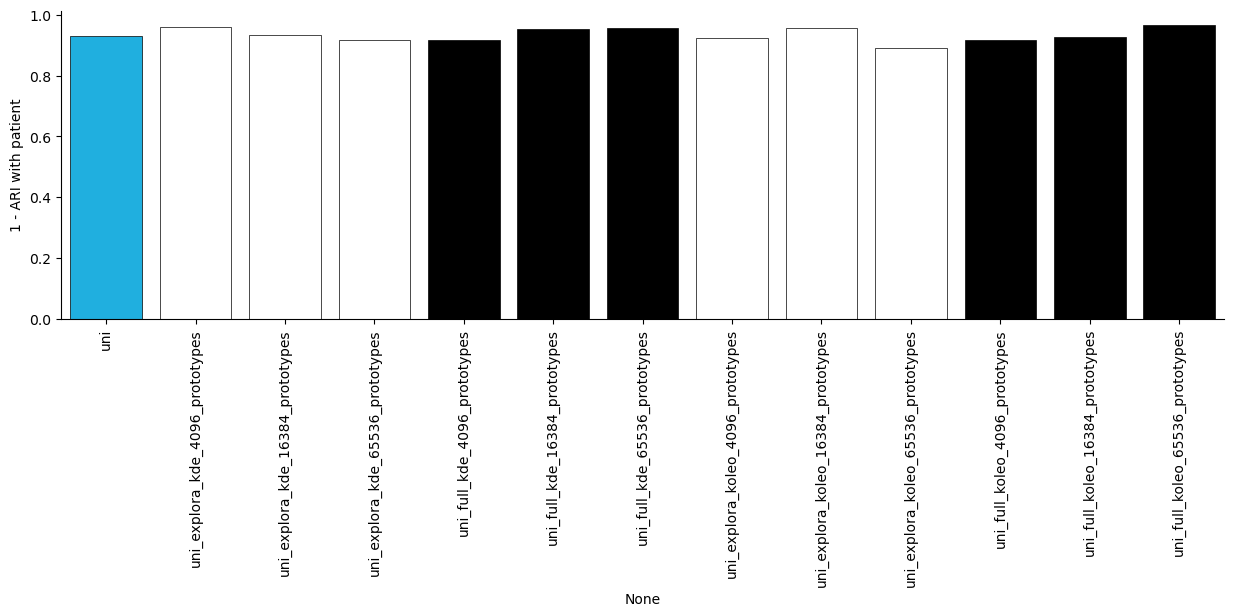

In [ ]:
### For vizualisation 

plt.figure(figsize=(15, 4))

# df_batch = df_batch.loc[["uni",
#               "uni_explora_kde_4096_prototypes",
#               "uni_explora_kde_8192_prototypes",
#               "uni_explora_kde_16384_prototypes",
#               "uni_explora_kde_32768_prototypes",
#                 "uni_explora_kde_65536_prototypes",
#                 "uni_full_kde_4096_prototypes",
#                 "uni_full_kde_8192_prototypes",
#                 "uni_full_kde_16384_prototypes",
#                 "uni_full_kde_32768_prototypes",
#                 "uni_full_kde_65536_prototypes",
#                 "uni_explora_koleo_4096_prototypes",
#                 "uni_explora_koleo_8192_prototypes",
#                 "uni_explora_koleo_16384_prototypes",
#                 "uni_explora_koleo_32768_prototypes",
#                 "uni_explora_koleo_65536_prototypes",
#                 "uni_full_koleo_4096_prototypes",
#                 "uni_full_koleo_8192_prototypes",
#                 "uni_full_koleo_16384_prototypes",
#                 "uni_full_koleo_32768_prototypes",
#                 "uni_full_koleo_65536_prototypes"]].drop_duplicates("ARI")
df_batch = df_batch.loc[["uni",
              "uni_explora_kde_4096_prototypes",
              "uni_explora_kde_16384_prototypes",
                "uni_explora_kde_65536_prototypes",
                "uni_full_kde_4096_prototypes",
                "uni_full_kde_16384_prototypes",
                "uni_full_kde_65536_prototypes",
                "uni_explora_koleo_4096_prototypes",
                "uni_explora_koleo_16384_prototypes",
                "uni_explora_koleo_65536_prototypes",
                "uni_full_koleo_4096_prototypes",
                "uni_full_koleo_16384_prototypes",
                "uni_full_koleo_65536_prototypes"]].drop_duplicates("ARI")
sns.barplot(df_batch, 
            x=df_batch.index, 
            y="batch effect", 
#             palette=["deepskyblue", "white", "white", "white", "white", "white", "black", "black", "black","black", "black", "white", "white", "white", "white", "white", "black", "black", "black", "black","black", ], 
            palette=["deepskyblue", "white", "white", "white", "black","black", "black", "white", "white", "white", "black", "black","black", ], 

            linewidth=0.5,
            edgecolor="black",
            )
plt.ylabel("1 - ARI with patient")
plt.xticks(rotation=90)
sns.despine()